<a href="https://colab.research.google.com/github/MykhailoFokin/segmentation/blob/master/Segmentation_github2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MykhailoFokin/segmentation

Cloning into 'segmentation'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 223 (delta 98), reused 117 (delta 92), pack-reused 96
Receiving objects: 100% (223/223), 32.57 MiB | 36.25 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [2]:
!pip install segmentation-models
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

#!pip install --upgrade tensorflow tensorflow-tensorboard
#!pip uninstall tensorflow-tensorboar

#!pip install tensorboard
#!pip install keras-rectified-adam

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1dkyc727
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1dkyc727
     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=4ee8b631a56162b50e70ed6d8df0c05b29d692641c3fb13d43954c6d154799e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-cl6kyxzf/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=7736344b214f7647930a10030c8db0fdb9d166ef2fac2f46eade4d5fdb40568e
  Stored in directory: /tmp/pip-ephem-wheel-cache-cl6kyxzf/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [3]:
import os
os.environ['TF_KERAS'] = '1'

%tensorflow_version 1.x
%matplotlib inline

import json
import numpy as np
from pycocotools.coco import COCO
from tqdm import tqdm
from PIL import Image
import cv2
#import keras
import matplotlib.pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import efficientnet
#from keras_radam import RAdam

#sm.set_framework('tf.keras')

TensorFlow 1.x selected.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
# Define parameters
WORKDIR = 'segmentation'
CLASSES = {'score':1, 'stat':2, 'username':3}
RESIZE_SHAPE = (160, 160)
#RESIZE_SHAPE = (192, 192)
#RESIZE_SHAPE = (320, 320)
#RESIZE_SHAPE = (480, 320)
#RESIZE_SHAPE = (640, 640)

#sm.set_framework('tf.keras')

#from tensorflow.keras.optimizers import Adam
# define optomizer
optim1 = 'Adam'
optim2 = keras.optimizers.Adam(lr=0.1, decay=0.000001)
#optim3 = RAdam(warmup_proportion=0.1, min_lr=0.000001)

optim = optim1

In [5]:
#WORKDIR = 'segmentation'
COCO_JSON = os.path.join(WORKDIR, 'pubg.json')

#CLASSES = {'score':1, 'stat':2, 'username':3}

with open(COCO_JSON) as json_file:
    data = json.load(json_file)

coco_instance = COCO(COCO_JSON)
coco_imgs = coco_instance.imgs
cat_ids = coco_instance.getCatIds(catNms=['games'])

masks_together = []
for i, img in enumerate(coco_imgs):
  anns_ids = coco_instance.getAnnIds(img, cat_ids)
  anns = coco_instance.loadAnns(anns_ids)

  h = coco_imgs[img]['height']
  w = coco_imgs[img]['width']
  class_mask = np.zeros((h, w))
  for ann in anns:
    mask = coco_instance.annToMask(ann)
    class_mask = class_mask + CLASSES[ann['metadata']['name']] * mask
    
  masks_together.append({
        'img': coco_imgs[img]['file_name'],#.rstrip(".jpg") + '.png',
        'mask': class_mask.astype('uint8')
    })

!mkdir '$WORKDIR/masks'
!mkdir '$WORKDIR/masks/pubg'

for mask in tqdm(masks_together, 'Save masks'):
    mask_image = Image.fromarray(mask['mask'])
    mask_image.save(
        os.path.join(WORKDIR, 'masks/pubg', mask['img']))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Save masks: 100%|██████████| 89/89 [00:01<00:00, 78.72it/s]


Dataloader and utility functions

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['score', 'stat', 'username']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            resize_shape=RESIZE_SHAPE,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.resize_shape = resize_shape
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        if (self.resize_shape) :
          image = cv2.resize(image,self.resize_shape, interpolation = cv2.INTER_NEAREST).astype(np.float32)
          #image = cv2.resize(image,self.resize_shape)#.astype(np.float32)
          #mask = cv2.resize(mask,self.resize_shape)#.astype(np.float32)
          mask = cv2.resize(mask,self.resize_shape, interpolation = cv2.INTER_NEAREST).astype(np.float32)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('uint8')
        #mask = np.stack(masks, axis=-1).astype(np.float32)
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return (len(self.indexes) // self.batch_size)
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


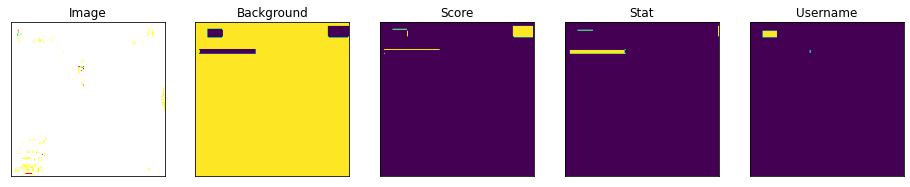

In [7]:
x_train_dir = os.path.join(WORKDIR, 'datasets', 'pubg')
y_train_dir = os.path.join(WORKDIR, 'masks','pubg')

# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['score', 'stat', 'username'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    score=mask[..., 1].squeeze(),
    stat=mask[..., 2].squeeze(),
    username=mask[..., 3].squeeze(),
)

### Augmentations

In [0]:
#!pip install -U albumentations>=0.3.0 --user 

In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.VerticalFlip(p=0.5), 

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=(-0.5,0), rotate_limit=4, shift_limit=0, p=0.9, border_mode=0),

        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        
        #A.RandomCrop(height=320, width=320, always_apply=True),
        #A.IAAAdditiveGaussianNoise(p=0.2),
        #A.IAAPerspective(p=0.5),

        #A.OneOf(
        #    [
        #        A.CLAHE(p=1),
        #        A.RandomBrightness(p=1),
        #        A.RandomGamma(p=1),
        #    ],
        #    p=0.9,
        #),

        #A.OneOf(
        #    [
        #        A.IAASharpen(p=1),
        #        A.Blur(blur_limit=3, p=1),
        #        A.MotionBlur(blur_limit=3, p=1),
        #    ],
        #    p=0.9,
        #),

        #A.OneOf(
        #    [
        #        A.RandomContrast(p=1),
        #        A.HueSaturationValue(p=1),
        #    ],
        #    p=0.9,
        #),
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform, p=1)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


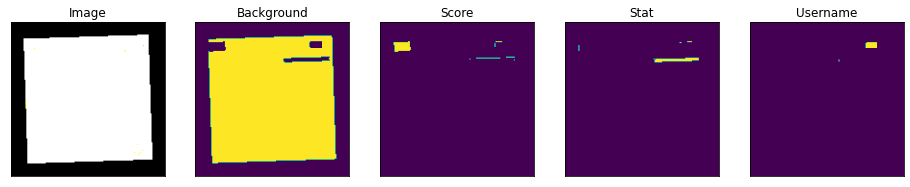

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


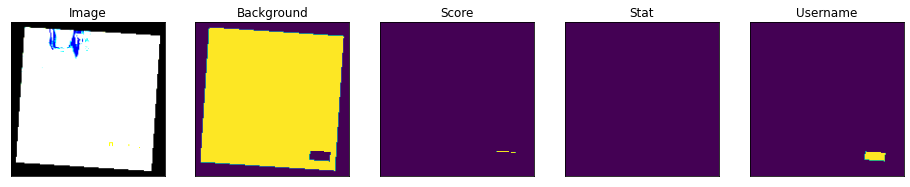

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


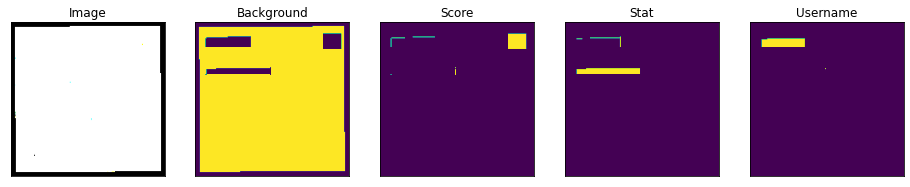

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


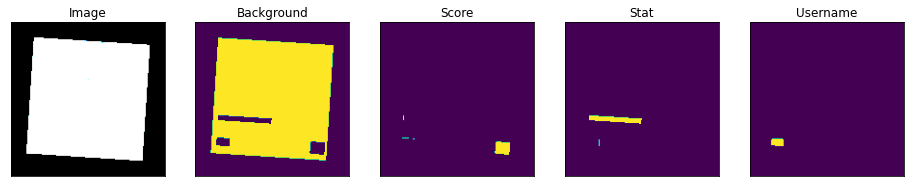

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


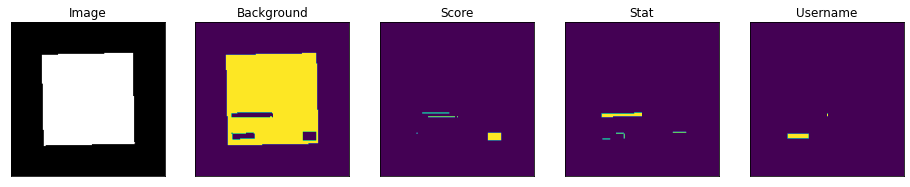

In [11]:
x_train_dir = os.path.join(WORKDIR, 'datasets', 'pubg')
y_train_dir = os.path.join(WORKDIR, 'masks','pubg')

# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['score','stat','username'], augmentation=get_training_augmentation())

list_to_show = (5,15,18,47,74)

for i in list_to_show :
  image, mask = dataset[i] # get some sample
  visualize(
      image=image, 
      background=mask[..., 0].squeeze(),
      score=mask[..., 1].squeeze(),
      stat=mask[..., 2].squeeze(),
      username=mask[..., 3].squeeze(),
  )

In [12]:
import shutil
import random

if (os.path.exists('$WORKDIR/model')) :
  !mkdir '$WORKDIR/model'
  !mkdir '$WORKDIR/model/pubg'
  !mkdir '$WORKDIR/model/pubg/train'
  !mkdir '$WORKDIR/model/pubg/trainannot'
  !mkdir '$WORKDIR/model/pubg/val'
  !mkdir '$WORKDIR/model/pubg/valannot'
  !mkdir '$WORKDIR/model/pubg/test'
  !mkdir '$WORKDIR/model/pubg/testannot'



  #dirListing = os.listdir(os.path.join(WORKDIR, 'datasets', 'pubg'))
  files = []
  # r=root, d=directories, f = files
  for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'pubg')):
      for file in f:
          if '.jpg' in file:
              #files.append(os.path.join(r, file))
              if 'pubg_100.jpg'!=file:
                files.append(file)

  filesCount = len(files)

  for i, file in enumerate(files):
    if (i<filesCount*0.8):
      shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','train',file))
      shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','trainannot',file))
    else :
      shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','val',file))
      shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','valannot',file))
    #elif (filesCount*0.8<=i<filesCount*0.9):
    #  shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','val',file))
    #  shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','valannot',file))
    #else:
    #  shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','test',file))
    #  shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model', 'pubg','testannot',file))

  print('Done!')

if (os.path.exists('$WORKDIR/model2')==False) :

  !mkdir '$WORKDIR/model2'
  !mkdir '$WORKDIR/model2/pubg'
  !mkdir '$WORKDIR/model2/pubg/train'
  !mkdir '$WORKDIR/model2/pubg/trainannot'
  !mkdir '$WORKDIR/model2/pubg/val'
  !mkdir '$WORKDIR/model2/pubg/valannot'
  !mkdir '$WORKDIR/model2/pubg/test'
  !mkdir '$WORKDIR/model2/pubg/testannot'

  #dirListing = os.listdir(os.path.join(WORKDIR, 'datasets', 'pubg'))
  files = []
  # r=root, d=directories, f = files
  for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'pubg')):
      for file in f:
          if '.jpg' in file:
              #files.append(os.path.join(r, file))
              if 'pubg_100.jpg'!=file:
                files.append(file)

  filesCount = len(files)

  for i, file in enumerate(files):
    if (i<filesCount*0.8):
      shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model2', 'pubg','train',file))
      shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model2', 'pubg','trainannot',file))
    else :
      shutil.copyfile(os.path.join(WORKDIR, 'datasets', 'pubg',file), os.path.join(WORKDIR, 'model2', 'pubg','val',file))
      shutil.copyfile(os.path.join(WORKDIR, 'masks', 'pubg',file), os.path.join(WORKDIR, 'model2', 'pubg','valannot',file))


print('Already done!')

Already done!


**Generate albumented data**

You can configure how much new images do you need.

In [0]:
x_train_dir = os.path.join(WORKDIR, 'model2', 'pubg','train')
y_train_dir = os.path.join(WORKDIR, 'model2', 'pubg','trainannot')

# how much examples do we need? 
GENERATE_ALBUMENTED_IMAGES_COUNT = 5

# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['score','stat','username'], augmentation=get_training_augmentation())

for x in range(GENERATE_ALBUMENTED_IMAGES_COUNT) :

  k = 0
  for i in range(len(dataset)):
    image, mask = dataset[i]
    k+=1
    cv2.imwrite(os.path.join(WORKDIR, 'model2', 'pubg','train','pubg_a_' + str(k + x*len(dataset)) + '.jpg'), image );
    mask_to_img = np.zeros_like(image)
    mask_to_img[:,:,0] = np.maximum(mask[..., 1], mask[..., 2]*2, mask[..., 3]*3)
    mask_to_img[:,:,1] = np.maximum(mask[..., 1], mask[..., 2]*2, mask[..., 3]*3)
    mask_to_img[:,:,2] = np.maximum(mask[..., 1], mask[..., 2]*2, mask[..., 3]*3)
    img_file_name = os.path.join(WORKDIR, 'model2', 'pubg','trainannot','pubg_a_' + str(k+ x*len(dataset)) + '.jpg')
    cv2.imwrite(img_file_name, mask );
    #print(k)


#dataset = Dataset(x_valid_dir, y_valid_dir, classes=['score','stat','username'], augmentation=get_training_augmentation())

#for x in range(10) :

#  k = 0
#  for i in range(len(dataset)):
#    image, mask = dataset[i]
#    k+=1
#    cv2.imwrite(os.path.join(WORKDIR, 'model', 'pubg','train','pubg_a_' + str(k + x*len(dataset)) + '.jpg'), image );
#    mask_to_img = np.zeros_like(image)
#    mask_to_img[:,:,0] = mask[..., 1]
#    mask_to_img[:,:,1] = mask[..., 2]
#    mask_to_img[:,:,2] = mask[..., 3]
#    img_file_name = os.path.join(WORKDIR, 'model', 'pubg','trainannot','pubg_a_' + str(k+ x*len(dataset)) + '.jpg')
#    cv2.imwrite(img_file_name, mask );

## Segmentation model training

In [0]:
#!pip install -U --pre segmentation-models --user
#!pip install segmentation-models
#!pip install imantics

In [0]:
#import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`
#sm.set_framework('tf.keras')

In [0]:
#BACKBONE = 'efficientnetb7'#'resnet34'
BACKBONE = 'efficientnetb7'#'resnet34'
BATCH_SIZE = 16
CLASSES = ['score', 'stat', 'username']
LR = 1
EPOCHS = 20

preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'


# define number of channels
N = n_classes#x.shape[-1]

#base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet')

#inp = Input(shape=(None, None, N))
#l1 = keras.layers.BatchNormalization()(inp)
##l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)

#model = Model(inp, out, name=base_model.name)



#create model
model = sm.Unet(BACKBONE, 
                input_shape=(RESIZE_SHAPE[1], RESIZE_SHAPE[0], 3), 
                classes=n_classes, 
                activation=activation,
                encoder_weights='imagenet',
                #decoder_use_batchnorm=True,
)
#base_model=model

#inp = keras.layers.Input(shape=(3, (320, 320, N))
#l1 = keras.layers.BatchNormalization()(inp)
#out = base_model(l1)
#model = Model(inp, out, name=base_model.name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
258441216/258434480 [==============================] - 3s 0us/step


In [0]:
#from tensorflow.keras.optimizers import Adam
# define optomizer
#optim1 = 'Adam'
#optim2 = keras.optimizers.Adam(lr=LR, decay=0.000001)
#optim3 = RAdam(warmup_proportion=0.1, min_lr=0.000001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 3, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
#total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

#metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
metrics = [sm.metrics.IOUScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
#model.compile(optim, total_loss, metrics)
model.compile(
    optim,
    loss=sm.losses.bce_jaccard_loss,
    #loss=total_loss,
    metrics=metrics)

#model.compile(
#    'Adam',
#    loss=sm.losses.bce_jaccard_loss,
#    metrics=[sm.metrics.iou_score])

In [19]:
WORKDIR = 'segmentation'
x_train_dir = os.path.join(WORKDIR, 'model2', 'pubg','train')
y_train_dir = os.path.join(WORKDIR, 'model2','pubg','trainannot')

x_valid_dir = os.path.join(WORKDIR, 'model2', 'pubg','val')
y_valid_dir = os.path.join(WORKDIR, 'model2', 'pubg','valannot')

x_test_dir = os.path.join(WORKDIR, 'model2', 'pubg','test')
y_test_dir = os.path.join(WORKDIR, 'model2', 'pubg','testannot')

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    resize_shape=RESIZE_SHAPE,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    resize_shape=RESIZE_SHAPE,
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, RESIZE_SHAPE[1], RESIZE_SHAPE[0], 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, RESIZE_SHAPE[1], RESIZE_SHAPE[0], n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    #keras.callbacks.ModelCheckpoint('./best_model.h5', verbose=1, monitor='val_iou_score', save_weights_only=True, save_best_only=True, mode='max'),
    #keras.callbacks.ReduceLROnPlateau(),
    #keras.callbacks.EarlyStopping(),
    keras.callbacks.TensorBoard(),
    #keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1),
]

(16, 160, 160, 3)
(16, 160, 160, 4)


In [0]:
# Shapes for each batch
#for i,j in enumerate(train_dataloader):
#  print(train_dataloader[i][0].shape)
#  print(train_dataloader[i][1].shape)

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
27/27 [==============================] - 839s 31s/step - loss: 1.0460 - iou_score: 0.1956 - val_loss: 1.0241 - val_iou_score: 0.2540
Epoch 2/20
27/27 [==============================] - 784s 29s/step - loss: 0.7439 - iou_score: 0.3265 - val_loss: 1.6300 - val_iou_score: 0.1893
Epoch 3/20
17/27 [=================>............] - ETA: 4:52 - loss: 0.6196 - iou_score: 0.4246

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [0]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
    resize_shape=RESIZE_SHAPE,
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [0]:
# Сохранение весов в файл HDF5
#model.save_weights('best_model.h5', save_format='h5')
#model.save_weights('best_model.h5')

# load best weights
#model.load_weights('best_model.h5') 

In [0]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [0]:
#X = test_dataloader
#evals = [model.evaluate(X[i:i+1], Y[i:i+1]) for i in range(len(X))]

#print(evals)

In [0]:
model.summary()

# Visualization of results on test dataset

In [0]:
import keras_preprocessing.image.utils as image_utils
n = 8
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

print(ids)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    gt_mask = image_utils.img_to_array(gt_mask)
    
    visualize(
        image=denormalize(image.squeeze()),
        score_gt_mask=gt_mask[..., 1].squeeze(),
        stat_gt_mask=gt_mask[..., 2].squeeze(),
        username_gt_mask=gt_mask[..., 3].squeeze(),
        #pr_mask=pr_mask.squeeze(),
        score=pr_mask[..., 1].squeeze(),
        stat=pr_mask[..., 2].squeeze(),
        username=pr_mask[..., 3].squeeze(),
    )

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save('model_complete.h5')